# CIS 545 Homework 5: Deep Learning - Due December 5th 2019

Welcome to CIS 545 Homework 5! 

In this homework, we will learn more about the 'new electricity' - Deep Learning (I didn't coin this, Andrew NG did) ! We will be learning how to use Tensorflow (sorry pytorch users!)with Keras - a machine learning library widely used everywhere, for different machine learning problems. Deep learning or neural network architectures have been used to solve a multitude of problems in various different fields like vision, natural language processing. So let's take a 'deep' dive into it.


![alt text](http://4.bp.blogspot.com/-sLgBLS3bJO8/U__Kx6PnkRI/AAAAAAAAAWM/Gz3cL5jiwTo/s320/godeeper.jpg)





## Why deep learning? 


*   It's coooool
*   Everyone is talking about is these days, People like Siraj Raval can teach it in 5 mins (Check out his youtube channel for some comedy)
*    Deep learning unlocks the treasure trove of unstructured big data for those with the imagination to use it
*   Deep learning models have great representational power and are 'universal approximators'


### Deep Learning Applications:


Deep learning has been significantly improved voice command systems (such as Siri and Alexa), as well as healthcare and image identification.

Deep learning has applications across numerous industries, which is why experts think that this technology is the future of almost everything. There are truly deep learning technologies such as Google’s very human-like talking AI, a new theory that cracks the 'black box' of deep learning, and various budding ideas like this one about why human forgetting might be the key to AI. Here are some cool applications of deep learning - 

Here's a neural network detecting anomalies in Chest Xrays :




![alt text](https://imgur.com/HKPzrzP.jpg)

Most humans can't tell that this is a case of Pleural Effusion {sounds like medical jargon to engineers like us} but this Neural Network model can detect it very well!

Mask RCNNs in action for detecting objects on the road aiding a self driving vehicle's driving: 
![alt text](https://miro.medium.com/max/3864/1*O4wsvh0CHWjP6IrK9HI_Zg.png)

Pretty cool, right? We will be training deep learning models in this assignment for some cool problems :)


Firstly, we will be appling CNNs to a Image Classification problem and later apply RNN/LSTMs to a XXXXX problem. So let's get started!


## Initializing the Penn Grader (formerly known as The Galant Grader) 

In [0]:
# TODO: Fill your Penn ID here
STUDENT_PENN_ID = 30205907

In [0]:
import json
import urllib.request
import dill
import base64

api_endpoint = 'https://d9w676u8n0.execute-api.us-east-1.amazonaws.com/default/PennGrader'

class PennGrader:

    def __init__(self, student_id, homework_id = 'CIS545_Fall19_HW5'):
        if student_id == None:
            print('Error Autograder Not Setup: Enter your 8 digit PennID in the cell above.') 
        self.student_id         = str(student_id)
        self.api_endpoint       = api_endpoint
        self.class_homework_id  = homework_id 
        
    def grade(self, test_case_id, answer):
        student_test_case_id = self.student_id + '_' + test_case_id
        payload = {'student_test_case_id'   : student_test_case_id,
                   'class_homework_id'      : self.class_homework_id,
                   'test_case_id'           : test_case_id,
                   'answer'                 : self.serialize(answer)}
        params = json.dumps(payload).encode('utf-8')
        request = urllib.request.Request(self.api_endpoint, 
                                         data    = params, 
                                         headers = {'content-type': 'application/json'})
        try:
            response = urllib.request.urlopen(request)
            response_body = response.read().decode('utf-8')
            print('{}'.format(response_body))
        except:
            print('Error: Grading request could not be completed.')

    def serialize(self, obj):
        byte_serialized = dill.dumps(obj)
        return base64.b64encode(byte_serialized).decode("utf-8")
        
    def deserialize(self, obj):
        byte_decoded = base64.b64decode(obj)
        return dill.loads(byte_decoded)

grader = PennGrader(student_id = STUDENT_PENN_ID, homework_id = 'CIS545_Fall19_HW5') 

# Section 1 : Image Analysis - The Convoluted Convolutional Neural Networks

In this section, we will make neural networks that learn to recognize emotion from face images (It is important for skynet to understand emotion before it takes over the world)

Here is a sample image from the dataset we will be using : 

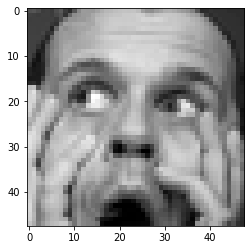

You can use your human knowledge to guess that this person looks pretty **surprised**. Let's see how we can build a model which can do that

## 1.1 : Data, data and more data
The data for this part consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. Your task here is to categorize each face based on the emotion shown in the facial expression in to one of seven categories : 

0.   Angry
1.   Disgust
2.   Fear
3.   Happy
4.   Sad
5.   Surprise
6.   Neutral

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. 


**Note:** First make sure that you have the runtime setup to use GPUs. 
Click on the runtime tab -> Change runtime type -> Select hardware accelerator as GPU

In [0]:
# Downloading the data
%%capture
!wget https://cis.upenn.edu/~cis545/data/face_expression_data.csv.zip
!unzip face_expression_data.csv.zip

In [0]:
# Read in the data

import pandas as pd
import cv2
import numpy as np
 
dataset_path = 'face_expression_data.csv'
image_size=(48,48)

def load_face_expression_dataset():
    '''
        TODO: Complete this function
        1. Read in the data from dataset_path into a pandas dataframe
        2. convert the 'pixels' column to a list and convert pixel sequence of each row in image of dimension 48*48
    '''
    data = pd.read_csv(dataset_path) # dataframe :(35887, 3)
    pixels = data['pixels'].tolist()
    width, height = image_size
    faces = []
    for pixel_sequence in pixels:
        #TODO: split pixel sequence on a separator to get the face pixels
        face_pixel= pixel_sequence.split(" ") # length = 2304 = 48 * 48, but every item is str
        face_pixel = [float(i) for i in face_pixel] # change str to float

        #TODO: Convert face list to a numpy array and reshape into the shape (width, height)
        faces_np = np.asarray(face_pixel).reshape(width, height) # 48 * 48

        #TODO: Resize the face to the image_size defined above. 
        #Hint: cv2 might have something you need
        face = cv2.resize(faces_np, (width, height), interpolation = cv2.INTER_CUBIC)

        #TODO: Add the face back to faces array
        faces.append(face)

    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    # Get one hot encoded emotions
    emotions = pd.get_dummies(data['emotion']).as_matrix() # emotions.size = (35887, 7)
    return faces, emotions
 
def preprocess_input(face_image):
    '''
        TODO: Implement this function
        It is a standard way to pre-process images by scaling them between -1 to 1. 
        Face images are scaled to [0,1] by dividing it by 255 (Make sure to convert integer images to floats before)
        Further, subtraction by 0.5 and multiplication by 2 changes the range to [-1,1]
    '''
    face_image = (face_image / 255 - 0.5) * 2
    return face_image




In [0]:
# Call the functions to create the dataset 
# Might take a little bit to run
faces, emotions = load_face_expression_dataset()
faces = preprocess_input(faces)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Report the number of faces in the dataset in the cell below

In [0]:
# TODO: Fill in the number of examples in the dataset
print(faces.shape)

number_examples = 35887

(35887, 48, 48, 1)


In [0]:
# Data preprocessing sanity test - worth 5 points
grader.grade(test_case_id = '1.1a', answer = (number_examples, faces[0]))

Correct! You earned 5/5 points. You are a star!

Your submission has been succesfully recorded in the gradebook.
               


Split the data into a training and testing subset. Use a random 80-20 split (80% of the data will form the training set and 20% of the data will form the test set). The test set will consist of images which the neural network has never seen before and they will be used to evaluate the performance of the network. Split the dataset into 

```
x_train, y_train -> The faces and corresponding emotions in the training set
x_test, y_test-> The faces and corresponding emotions in the test set
```



In [0]:
# TODO: Split the dataset into x_train, y_train, x_test, y_test 
# Hint: sklearn is your friend!
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.2, random_state=42)

In [0]:
#Test the data split - worth 3 points
grader.grade(test_case_id = '1.1b', answer = (x_train.shape, y_train.shape, x_test.shape, y_test.shape, number_examples))

Correct! You earned 3/3 points. You are a star!

Your submission has been succesfully recorded in the gradebook.
               


### 1.1.1 : Understanding the data

We have our training and testing data but we humans don't really understand binary that well. So let's visualize what our data is by plotting some data points



![alt text](https://www.pathinteractive.com/wp-content/uploads/2018/01/data-mining-img-2-3.jpg)

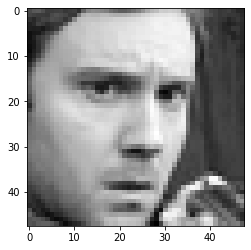

Angry


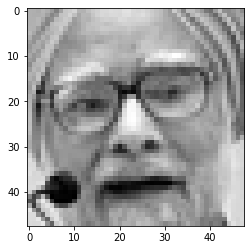

Angry


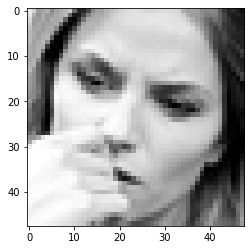

Fear


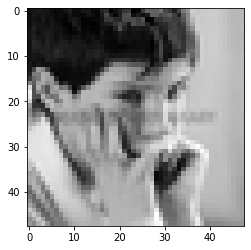

Sad


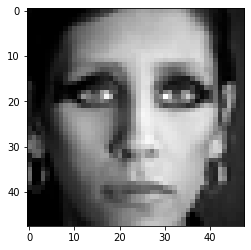

Neutral


In [0]:
# Visualize 5 images in the dataset with their corresponding emotion label
%matplotlib inline

import matplotlib.pyplot as plt

num_points = 5
plt.gray()
emotion_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise','Neutral']
# TODO: Visualize num_points images along with their emotion labels 
# (dataset has the index of teh emotion and ou can use the list above to get the corresponding emotion value)
# (You might have to scale it back up to see the image)
for i in range(num_points):
  # plot the image
  plt.imshow(np.squeeze(faces[i]))
  plt.show()
  # print the label
  label = emotions[i].tolist()
  print(emotion_names[label.index(1)])



### 1.1.2 : Emotion Frequencies

Create a dictionary with the number of faces belonging to each of the emotions. 

In [0]:
'''
    TODO: Complete the function that creates a dictionary keyed on the emotion name and the number of faces
    in the training set for the corresponding emotion as the value. 
'''

def create_emotion_count_dict(x_train, y_train, emotion_names):
    emotion_count_dict = {}
    #TODO : Complete this function
    for name in emotion_names:
      emotion_count_dict[name] = 0
    for label in y_train:
      emotion = emotion_names[label.tolist().index(1)]
      emotion_count_dict[emotion] = emotion_count_dict.get(emotion) + 1
         
    return emotion_count_dict

emotion_count_dict = create_emotion_count_dict(faces, emotions, emotion_names)
print(emotion_count_dict)

{'Angry': 4953, 'Disgust': 547, 'Fear': 5121, 'Happy': 8989, 'Sad': 6077, 'Surprise': 4002, 'Neutral': 6198}


Which emotion is the most frequent in the dataset? which is the least? Are the number of examples for each class balanced? Think if this will affect model performance in any way

In [0]:

most_frequent_class = "Happy" # TODO : Assign this to the most frequent class name
least_frequent_class = "Disgust" # TODO : Assign this to the least frequent class name

In [0]:
#Test the created dictionary and frequency analysis - worth 5 points
grader.grade(test_case_id = '1.1.2', answer = (emotion_count_dict, most_frequent_class))


Correct! You earned 5/5 points. You are a star!

Your submission has been succesfully recorded in the gradebook.
               


We will create a batch of images which stacks batch_size number of images together and passes them to the network together to speed up the training process. Creating these "mini batches" and when doing gradient descent with these mini batches i.e. mini-batch gradient descent seeks to find a balance between the robustness of stochastic gradient descent and the efficiency of batch gradient descent. 

Optional: If you are interested in learning about mini batch gradient descent, read up [this](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) post!

In [0]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Create batched data generator
batch_size = 8
gen = ImageDataGenerator()
# Create a generator function for the training data
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

Using TensorFlow backend.


## 1.2 : Convoluted Convolutional Neural Networks


Now we know what the data is like. Let's get to building a model with keras which can detect the emotions from these face images. We will be using a CNN as our model.


**So, what are CNNs?**

Convolutional Neural Networks are very similar to ordinary Neural Networks from the previous chapter: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. 

So what changes? ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

If you wanna know more about how CNNs function and see some cool visualizations, we would highly recommend [this](http://cs231n.github.io/convolutional-networks/) page 




In [0]:
# Some technical jargon to set up tensorflow session for keras and make it use the GPU
import tensorflow as tf
import keras
#cpu - gpu configuration
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} ) #max: 1 gpu, 56 cpu
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

## 1.2.1 : Logical Logistic Regression - Baseline

To see how well CNNs work for such problems, we need to compare them to a baseline model. Let's first try solving this problem with a Logistic Regression classifier solving the 7-class multiclass classification problem.

Define a logistic regression model in keras and fit that to the training data

model.compile() function can assign a optimizer, loss function and metrics you will be using for your problem.
Use that function to assign SGD (Stochastic Gradient Descent) as the optimizer, categorical cross entropy loss as the objective function and train the model for 20 epochs.



Since, this is a multi-class classification problem, we will use the categorical cross-entropy loss function. It is defined as:

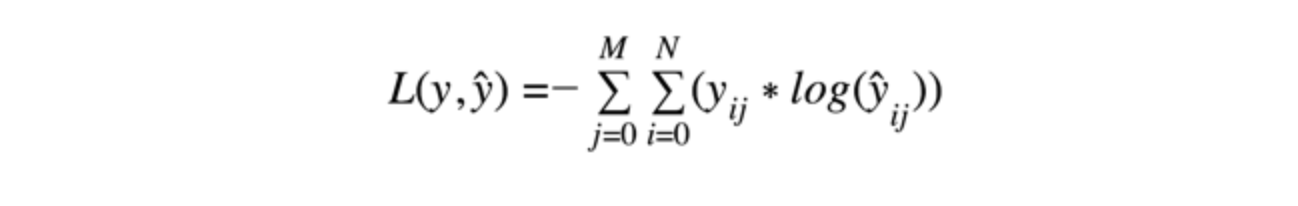

Luckily, we don't have to write it ourselves, we will use the implementation within keras.

Once the model has been training, compute and report the model accuracy on the test set.

In [0]:
''' 
    TODO: 1. Define the model - You would want to first flatten the 48,48 image data into a single dimensional vector
    2. Add stochastic gradient descent optimizer, 'categorical_crossentropy' as the objective/loss function
    3. Train it using SGD for 20 epochs (20 passes through the training data)
    4. Get the accuracy on the test set and assign it to lr_test_accuracy
'''
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras import optimizers
from sklearn.metrics import accuracy_score

# TODO: Implement logistic regression model
# Define the model
lr_model = Sequential()
# flatten to 1-D 
lr_model.add(Flatten())
lr_model.add(Dense(7))
lr_model.add(Activation('softmax'))
# train(using SGD for 20 epochs)
lr_model.compile(loss = 'categorical_crossentropy', optimizer= 'sgd', metrics= ['accuracy'])
lr_model.fit(x_train, y_train, epochs=20, verbose=1, validation_data=(x_test, y_test))
# get the accuracy on test data
lr_test_accuracy = lr_model.evaluate(x_test, y_test, verbose=0)[1]
print(lr_test_accuracy)

Train on 28709 samples, validate on 7178 samples
Epoch 1/20
28709/28709 [==============================] - 4s 143us/step - loss: 1.7533 - acc: 0.3181 - val_loss: 1.7337 - val_acc: 0.3321
Epoch 2/20
28709/28709 [==============================] - 4s 143us/step - loss: 1.6754 - acc: 0.3551 - val_loss: 1.7450 - val_acc: 0.3252
Epoch 3/20
28709/28709 [==============================] - 4s 137us/step - loss: 1.6472 - acc: 0.3662 - val_loss: 1.7027 - val_acc: 0.3356
Epoch 4/20
28709/28709 [==============================] - 4s 142us/step - loss: 1.6284 - acc: 0.3766 - val_loss: 1.7207 - val_acc: 0.3429
Epoch 5/20
28709/28709 [==============================] - 4s 139us/step - loss: 1.6162 - acc: 0.3805 - val_loss: 1.7063 - val_acc: 0.3469
Epoch 6/20
28709/28709 [==============================] - 4s 139us/step - loss: 1.6043 - acc: 0.3841 - val_loss: 1.6619 - val_acc: 0.3554
Epoch 7/20
28709/28709 [==============================] - 4s 141us/step - loss: 1.5966 - acc: 0.3847 - val_loss: 1.6766 - v

Does the logistic regression fit well to the data? Think about whether this is underfitting or overfitting? Think about if we need more representational power or we need more regularization to make it better?

In [0]:
# TODO: Set this variable to True/False based on your answers to the above question
underfit = True


In [0]:
# Test for logistic regression model, model accuracy - worth 5 points
assert(lr_model != None)
grader.grade('1.2.1', (lr_test_accuracy, underfit))

Correct! You earned 5/5 points. You are a star!

Your submission has been succesfully recorded in the gradebook.
               


### 1.2.2 : Define the CNN model

Now we know logistic regression doesn't do great on this task. We saw that we need more representation power => we need more trainable parameters => neural networks might help us here!

Now, define a CNN model with Keras with the following layers:


1.   Convolution with 64 filters with kernel size 5x5 followed by ReLU activation function
2.   Max Pool with filter size/pool size = 5 and stride = 2
3.   Convolution with 64 filters with kernel size 3x3 followed by ReLU activation function
4.   Max Pool with filter size/pool size = 3 and stride = 2
5.   Convolution with 128 filters with kernel size 3x3 followed by ReLU activation function
6.   Max Pool with filter size/pool size = 3 and stride = 2
7. Flatten layer to transform 3D layers to a single tensor/vector
8. Fully Connected with 1024 neurons and ReLU activation function
8. Fully Connected with 1024 neurons and ReLU activation function
8. Fully Connected with 7 neurons (one for each class) and softmax activation function

The model output will be 7 class probabilities.




In [0]:
# TODO : Create the model structure using Keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

# Initialize keras sequential model
model = Sequential()
num_classes = 7

# Now we will create the layers for the model and add them to the sequential model

'''
Create the 1st convolution layer with 64 filters with kernel size 5x5
followed by a max pooling with a stride = 2 and pool_size = 5
(We created the first one for you :D ) 

'''
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

# TODO : Add the remaining convolutional and pooling layers
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
# TODO: Add a flatten operation
model.add(Flatten())
# TODO: Add the intermediate fully connected layers (Dense in keras)
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
# TODO: Add the final fully connected layer with the softmax activation function
model.add(Dense(7, activation='softmax'))

### 1.2.3 : Trainable Parameters

Now we have defined a model, but it hasn't seen any data yet. We now want to pass it the training data and update the model parameters using gradient descent. First let's see how many trainable parameters it has.

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)              

In [0]:
# TODO: Report the number of trainable parameters 
trainable_parameters = 1694535

In [0]:
# Test CNN model creation, worth 5 points
try:  
    grader.grade('1.2.3', trainable_parameters)
except:
    print("You probably didn't define your model correctly!")

Correct! You earned 5/5 points. You are a star!

Your submission has been succesfully recorded in the gradebook.
               


Now we initialize the optimizer along with our loss function i.e. the categorical cross-entropy loss function.

Now use the model.compile() function to define the loss function, optimizer and the metrics like you did for logistic regression. 

In [0]:
# TODO : associate the loss function, optimizer and accuracy as our metric for evaluation
model.compile(loss = 'categorical_crossentropy', optimizer= 'sgd', metrics=['accuracy'])

### 1.2.4 : Model Training
Now fit the model to the training data using train_generator you created before. Run it for 20 epochs (An epoch is one pass through the data). It should take ~ 15 mins if you are doing everything right. You can take a break while the model trains!

To visualize your loss and accuracy in realtime, log values to tensorboard to see graphs for the loss and accuracy. Read up how to connect your keras model to log values to tensorboard here : https://www.tensorflow.org/tensorboard/get_started


In [0]:
epochs = 20

# TODO : Fit the model to the training data and run the training for 20 epochs
model.fit_generator(train_generator, epochs=20)


Epoch 1/20
3589/3589 [==============================] - 33s 9ms/step - loss: 0.3316 - acc: 0.8802
Epoch 2/20
3589/3589 [==============================] - 32s 9ms/step - loss: 0.2993 - acc: 0.8932
Epoch 3/20
3589/3589 [==============================] - 32s 9ms/step - loss: 0.2701 - acc: 0.9036
Epoch 4/20
3589/3589 [==============================] - 32s 9ms/step - loss: 0.2300 - acc: 0.9197
Epoch 5/20
3589/3589 [==============================] - 32s 9ms/step - loss: 0.2034 - acc: 0.9295
Epoch 6/20
3589/3589 [==============================] - 32s 9ms/step - loss: 0.1780 - acc: 0.9409
Epoch 7/20
3589/3589 [==============================] - 32s 9ms/step - loss: 0.1632 - acc: 0.9463
Epoch 8/20
3589/3589 [==============================] - 32s 9ms/step - loss: 0.1434 - acc: 0.9521
Epoch 9/20
3589/3589 [==============================] - 31s 9ms/step - loss: 0.1279 - acc: 0.9593
Epoch 10/20
3589/3589 [==============================] - 31s 9ms/step - loss: 0.1122 - acc: 0.9648
Epoch 11/20
3589/35

Report the training loss and accuracy after the first and the last epoch. Is your model able to learn? i.e. Does the loss decrease and the accuracy increase after every epoch?

Please be honest in reporting the accuracies, we will be penalizing falsely reported scores heavily.

Is the model better than random guessing on images it has seen before?

In [0]:
# TODO: Fill in the values for these variables

training_loss_epoch_1 = model.history.history['loss'][0]
training_accuracy_epoch_1 = model.history.history['acc'][0]
training_loss_final = model.history.history['loss'][epochs - 1]
training_accuracy_final = model.history.history['acc'][epochs - 1]
print(training_accuracy_epoch_1, training_loss_epoch_1, training_loss_final, training_accuracy_final)

# Make True if model better than random guessing, False otherwise
is_model_better_than_random = True

0.8802117802779617 0.33163222912824203 0.046279017768236196 0.9866244034992373


In [0]:
# Test the trained model
actual_loss, actual_acc = model.evaluate(x_train, y_train)
answer = training_loss_epoch_1, training_accuracy_epoch_1, training_loss_final, training_accuracy_final, is_model_better_than_random, actual_acc, actual_loss
grader.grade('1.2.4', answer)

28709/28709 [==============================] - 5s 170us/step
Correct! You earned 5/5 points. You are a star!

Your submission has been succesfully recorded in the gradebook.
               


## 1.3 : Inference Time!

We would actually like to see how the results look like, let's plot some test images and the predictions of out model. Create a function which takes in the test images and the model and returns the predicted emotion label.

In [0]:
def get_predicted_emotion_labels(x_test, model):
    # TODO: Implement the function to return the predicted emotion labels for the model on the test set
    y_raw = model.predict(x_test)
    y_pred = np.argmax(y_raw, axis = 1)
    return y_pred
y_pred = get_predicted_emotion_labels(x_test, model)
y_pred

array([5, 3, 2, ..., 0, 6, 4])

In [0]:
# Testing get_predicted_emotion_labels function - worth 2 points

y_pred_test = get_predicted_emotion_labels(x_test, model)
grader.grade('1.3.0', (x_test.shape, y_pred_test))

Correct! You earned 2/2 points. You are a star!

Your submission has been succesfully recorded in the gradebook.
               


Now plot 5-10 face images sampled randomly and print the predicted and actual emotion strings (the actual emotion "angry" etc. rather than the numeric value) for those images. You can get the corresponding emotion predictions and the labels from the function created above.

Hint: Remember that the y_test labels are one-hot encoded where as y_pred labels are integer values
You can convert y_test to integers by doing an argmax along axis 1 (along the columns)

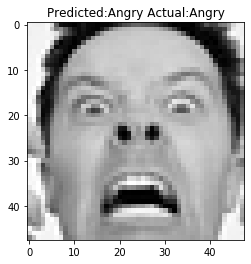

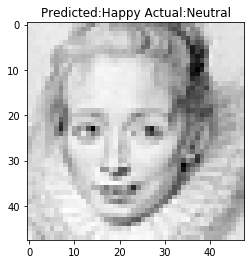

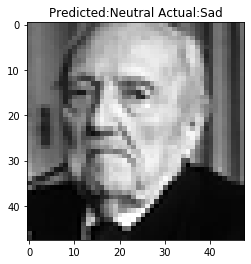

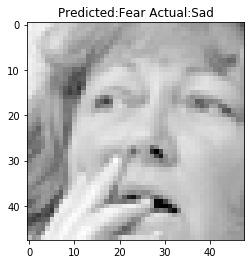

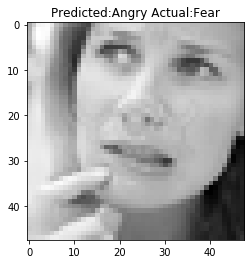

In [0]:
# TODO: Plot test images and print predicted and actual emotions
import random
def plt_test_images(x_test, y_test, y_pred, emotion_names, num_points = 5):
    for i in range(num_points):
    # plot the image
      index = random.randint(0, len(x_test))
      plt.figure()
      plt.imshow(np.squeeze(x_test[index]))
      
      # print the label
      pred_emotion = emotion_names[y_pred[index]]
      index_true = np.argmax(y_test[index], axis = 0)
      T = "Predicted:" + pred_emotion + " Actual:" + emotion_names[index_true]
      plt.title(T)
    
plt_test_images(x_test, y_test, y_pred, emotion_names, num_points = 5)

### 1.3.1 Accuracy

Now let's evaluate how the model does on data it has never seen before. Evaluate the model performance on the test set and report the accuracy. 
Again, please be honest in reporting the accuracy, if the reported accuracy doesn't match the actual accuracy by a margin, we will penalize the entire submission heavily.

In [0]:
# TODO : Evaluate the model on the test set and update the accuracy value in the variable below
from sklearn.metrics import classification_report
def compute_model_accuracy(y_test, y_pred):
  y_test = np.argmax(y_test, axis = 1)
  return accuracy_score(y_test, y_pred)



test_accuracy = compute_model_accuracy(y_test, y_pred)
print("Test accuracy of the model is : " , test_accuracy * 100, " %")

Test accuracy of the model is :  57.31401504597381  %


In [0]:
# Test model accuracy - worth 3 points
test_accuracy_t = compute_model_accuracy(y_test, y_pred)
answer = y_test, y_pred, test_accuracy_t
grader.grade('1.3.1', answer)

Correct! You earned 3/3 points. You are a star!

Your submission has been succesfully recorded in the gradebook.
               


### 1.3.2 Confusion Matrix

By definition a confusion matrix is a matrix of size NxN (where N is the number of classes) such that C[i,j] is equal to the number of observations known to be in group i  but predicted to be in group j. 
We then normalize this by dividing each cell in the matrix by the number of examples for the class i.e. the sum of element along the row for that cell

Create a confusion matrix to evaluate your model on the test set. 

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy
def create_confusion_matrix(y_pred, y_true):
    # Return a numpy array of shape NxN as described above
    y_true_lst = []
    for i in range(len(y_true)):
     
      for j in range(len(y_true[i])):
        if y_true[i][j] == 1:
          y_true_lst.append(j)
      
    y_true_array = numpy.array(y_true_lst)
    print(y_true_lst)

    matrix = np.zeros((y_true.shape[1], y_true.shape[1]))
    for i in range(len(y_true_array)):
      matrix[y_true_array[i]][y_pred[i]] += 1

    #y_true = np.argmax(y_true, axis = 1)
    #matrix = confusion_matrix(y_true, y_pred)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    return matrix

confusion_matrix = create_confusion_matrix(y_pred, y_test)
print(confusion_matrix)

[3, 6, 0, 4, 0, 6, 4, 2, 6, 2, 6, 3, 0, 0, 0, 4, 6, 2, 5, 0, 0, 4, 2, 5, 6, 3, 3, 4, 6, 4, 4, 3, 3, 5, 2, 5, 2, 6, 3, 3, 4, 6, 2, 6, 0, 3, 4, 3, 3, 3, 6, 2, 3, 2, 6, 4, 5, 5, 2, 6, 0, 5, 4, 0, 3, 6, 3, 0, 2, 3, 6, 4, 3, 2, 5, 3, 4, 3, 3, 3, 6, 2, 0, 2, 3, 4, 3, 5, 3, 4, 3, 3, 3, 6, 6, 5, 0, 2, 5, 2, 3, 4, 6, 6, 6, 2, 0, 2, 2, 5, 5, 4, 3, 3, 0, 0, 6, 3, 3, 3, 4, 0, 6, 3, 5, 4, 2, 2, 3, 4, 3, 2, 2, 5, 0, 2, 3, 3, 3, 0, 4, 3, 6, 3, 6, 0, 3, 2, 0, 3, 5, 0, 5, 2, 6, 0, 3, 3, 3, 5, 6, 4, 6, 5, 4, 3, 0, 2, 5, 6, 6, 2, 6, 4, 2, 4, 6, 6, 0, 6, 5, 5, 6, 6, 4, 2, 6, 6, 6, 2, 3, 5, 0, 6, 6, 5, 3, 3, 4, 5, 4, 4, 3, 5, 5, 2, 4, 3, 3, 6, 0, 0, 3, 2, 0, 0, 0, 4, 0, 3, 3, 2, 4, 3, 2, 0, 4, 3, 0, 4, 5, 4, 2, 3, 6, 3, 3, 4, 5, 6, 2, 6, 4, 5, 4, 1, 6, 5, 6, 5, 0, 0, 6, 5, 6, 3, 2, 4, 4, 2, 0, 2, 3, 4, 3, 3, 0, 0, 6, 2, 6, 2, 6, 0, 1, 6, 6, 0, 2, 5, 6, 0, 6, 3, 0, 4, 0, 3, 0, 2, 0, 6, 6, 2, 2, 5, 6, 5, 3, 6, 0, 0, 3, 6, 6, 6, 2, 5, 3, 3, 6, 5, 4, 2, 5, 3, 6, 0, 4, 4, 0, 2, 0, 2, 3, 4, 3, 3, 2, 0, 3, 4, 3, 

In [0]:
# Test Confusion Matrix - worth 5 points
confusion_matrix_test = create_confusion_matrix(y_pred, y_test)

grader.grade('1.3.2', confusion_matrix_test)


[3, 6, 0, 4, 0, 6, 4, 2, 6, 2, 6, 3, 0, 0, 0, 4, 6, 2, 5, 0, 0, 4, 2, 5, 6, 3, 3, 4, 6, 4, 4, 3, 3, 5, 2, 5, 2, 6, 3, 3, 4, 6, 2, 6, 0, 3, 4, 3, 3, 3, 6, 2, 3, 2, 6, 4, 5, 5, 2, 6, 0, 5, 4, 0, 3, 6, 3, 0, 2, 3, 6, 4, 3, 2, 5, 3, 4, 3, 3, 3, 6, 2, 0, 2, 3, 4, 3, 5, 3, 4, 3, 3, 3, 6, 6, 5, 0, 2, 5, 2, 3, 4, 6, 6, 6, 2, 0, 2, 2, 5, 5, 4, 3, 3, 0, 0, 6, 3, 3, 3, 4, 0, 6, 3, 5, 4, 2, 2, 3, 4, 3, 2, 2, 5, 0, 2, 3, 3, 3, 0, 4, 3, 6, 3, 6, 0, 3, 2, 0, 3, 5, 0, 5, 2, 6, 0, 3, 3, 3, 5, 6, 4, 6, 5, 4, 3, 0, 2, 5, 6, 6, 2, 6, 4, 2, 4, 6, 6, 0, 6, 5, 5, 6, 6, 4, 2, 6, 6, 6, 2, 3, 5, 0, 6, 6, 5, 3, 3, 4, 5, 4, 4, 3, 5, 5, 2, 4, 3, 3, 6, 0, 0, 3, 2, 0, 0, 0, 4, 0, 3, 3, 2, 4, 3, 2, 0, 4, 3, 0, 4, 5, 4, 2, 3, 6, 3, 3, 4, 5, 6, 2, 6, 4, 5, 4, 1, 6, 5, 6, 5, 0, 0, 6, 5, 6, 3, 2, 4, 4, 2, 0, 2, 3, 4, 3, 3, 0, 0, 6, 2, 6, 2, 6, 0, 1, 6, 6, 0, 2, 5, 6, 0, 6, 3, 0, 4, 0, 3, 0, 2, 0, 6, 6, 2, 2, 5, 6, 5, 3, 6, 0, 0, 3, 6, 6, 6, 2, 5, 3, 3, 6, 5, 4, 2, 5, 3, 6, 0, 4, 4, 0, 2, 0, 2, 3, 4, 3, 3, 2, 0, 3, 4, 3, 

### 1.3.3 Precision - Recall

Compute the precision and recall for each of the classes (i.e. each of the emotions)

Return a vector (a numpy array of shape (7)) for each precision and recall .

In case you need a refresher: 

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/26106935459abe7c266f7b1ebfa2a824b334c807)

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/4c233366865312bc99c832d1475e152c5074891b)




In [0]:
def compute_precision_recall(y_test, y_pred):
    precision = np.zeros((7))
    recall = np.zeros((7))
    #TODO : Complete this function
    for i in range(7):
      tp = confusion_matrix[i][i]
      fp = 0
      fn = 0
      for j in range(7):        
        fp += confusion_matrix[i][j]
        fn += confusion_matrix[j][i]
      fp -= confusion_matrix[i][i]
      fn -= confusion_matrix[i][i]

      precision[i] = tp / (tp + fp)
      recall[i] = tp / (tp + fn)
    print(precision, recall)
    return precision, recall

precision , recall = compute_precision_recall(y_test, y_pred)
print(emotion_names)
print("The precision vector = ", precision)
print("The recall vector = ", recall)

[0.47005076 0.47058824 0.36049856 0.76600567 0.49669421 0.64528302
 0.59546166] [0.45752002 0.96745743 0.47145302 0.60783045 0.38485056 0.81007223
 0.43334031]
['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
The precision vector =  [0.47005076 0.47058824 0.36049856 0.76600567 0.49669421 0.64528302
 0.59546166]
The recall vector =  [0.45752002 0.96745743 0.47145302 0.60783045 0.38485056 0.81007223
 0.43334031]


In [0]:
# Test precision-recall computation - worth 4 points

precision_test , recall_test = compute_precision_recall(y_test, y_pred)
grader.grade('1.3.3', (precision_test , recall_test))

[0.47005076 0.47058824 0.36049856 0.76600567 0.49669421 0.64528302
 0.59546166] [0.45752002 0.96745743 0.47145302 0.60783045 0.38485056 0.81007223
 0.43334031]
Correct! You earned 6/6 points. You are a star!

Your submission has been succesfully recorded in the gradebook.
               


Which class/emotion seems to have the best precision value? Which class/emotion has the worst?
Can you think of a reason why there is a significant difference in the performance?

In [0]:
best_class = "Happy" # which is the class with the best precision value
worst_class = "Fear" # which is the class with the worst precision value
reason = "Happy could be easily detected, Fear could not be easily found, which is similar to many other emotions." # why do you think this is happening? explain it in few words

In [0]:
# Test the above answers - worth 2 points
answer = emotion_names, precision_test, best_class, worst_class, reason 
grader.grade('1.3.3b', answer)

Correct! You earned 3/3 points. You are a star!

Your submission has been succesfully recorded in the gradebook.
               


## 1.4 : Fun Inference Exercise

![alt text](https://i.imgflip.com/dve0z.jpg)

Click a selfie trying to express one of the emotions we are trying to train the model to recognize (best to crop the image to just have your beautiful face). If you are too shy and  don't want to click a selfie, download a face image with some expression from Google instead :P. Convert it to grayscale and scale the image down to (48,48). Now pass it to your model and get the model prediction for your selfie. Upload that to your colab session (Files tab on the left -> Upload) 

For example: Here is a selfie of your TA Mr. Craig Fan (in grayscale) and he's predicted to be happy with a probability of 0.99 by the model we trained - 
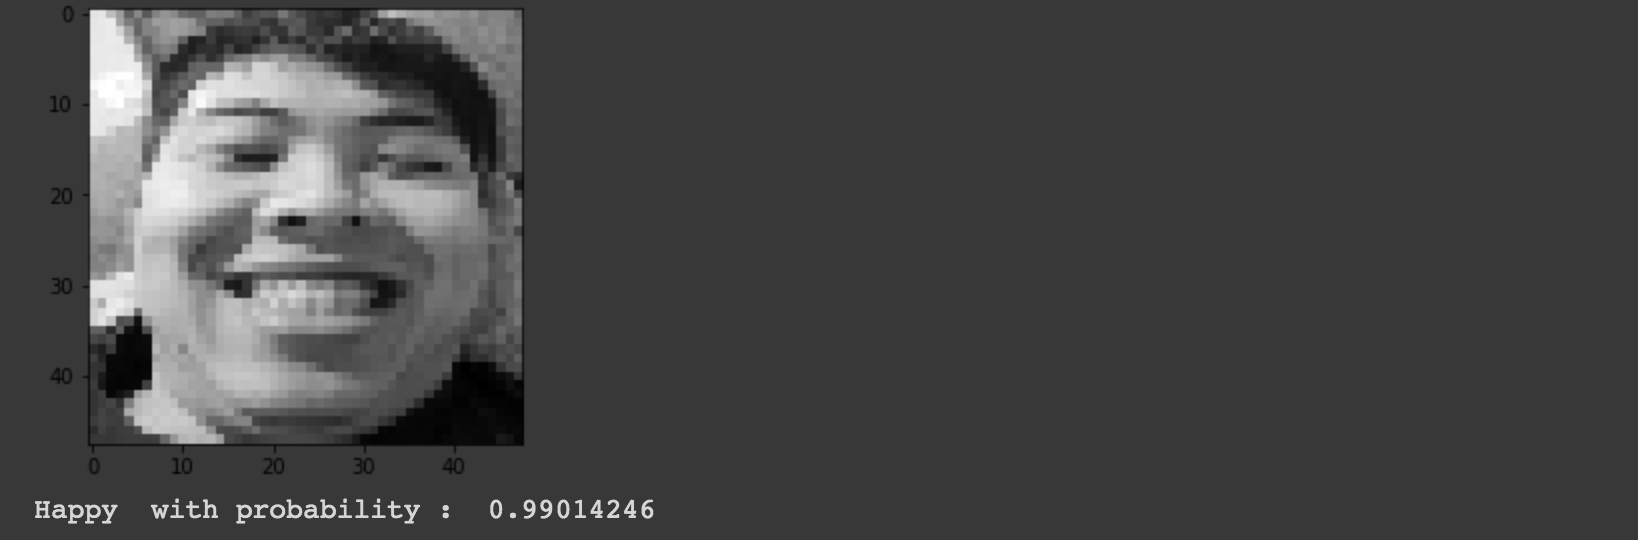


What emotion does your model predict for your selfie? Does the prediction make sense? If not, think what confused the model?

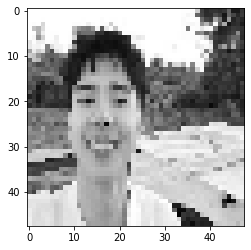

Happy  with probability :  0.99742776


In [0]:
# TODO: Click a selfie, upload it to colab, pass it to the process_new_image function 
# and get the prediction of the model on the processed image 
from keras.preprocessing import image

def process_new_image(filepath, target_size = (48,48)):
    '''
        TODO: Complete this function that loads the image from filepath provided (make sure you read it as grayscale),
        scales it to the target_size, call the preprocess function (written in 1.1 ) to normalize the image array to be in [-1,1]
        Hint: There are functions in the module imported at the start of this cell that you might find useful
    '''
    img = image.load_img(filepath, color_mode="grayscale", target_size=target_size)
    img_array = image.img_to_array(img)

    img_array = preprocess_input(img_array)
    return img_array

def load_image_from_file_and_predict(filepath, model):
    # Get the processed image file
    processed_image = process_new_image(filepath)
    # Add an extra dimension for the batch
    processed_image = np.expand_dims(processed_image, axis = 0)
    plt.imshow(processed_image[0,:,:,0])
    plt.show()
    # TODO : Get the model prediction
    image_prediction = model.predict(processed_image)
    print(emotion_names[np.argmax(image_prediction)], " with probability : ", np.max(image_prediction))
    return emotion_names[np.argmax(image_prediction)]
    
#TODO : Add the path of your selfie file
filepath = "star.jpeg" 
selfie_prediction_string = load_image_from_file_and_predict(filepath, model)



In [0]:
# Test process new image function - worth 5 points

assert(filepath.strip() != "")
new_processed_image = process_new_image(filepath)
answer = new_processed_image, selfie_prediction_string, emotion_names
grader.grade('1.4', answer)

Correct! You earned 5/5 points. You are a star!

Your submission has been succesfully recorded in the gradebook.
               


That ends this section. You taught your deep learning model how to recognize emotions. You obviously are a star!


The next section will teach you how to work with sequential data such as text, sounds, trajectories etc. We will be pivoting to a different sequential dataset for the next part. 

# Section 2: Sequential Data
Just kidding, we are cutting out the next section in order to give you enough time to focus on the project. Good Luck!

P.S. For those who are interested, the next part was gonna be emotion detection in texts using RNNs and LSTMs with GloVE word embeddings. 

Here's a short description: 

We will be teaching our model to learn the emotion from text data. We will implement a model which inputs a sentence (for example "I had so much fun at lunch with the CIS545 TAs") and finds the most appropriate emoji from a set of emojis to be used with this sentence ( 😄/🍴 )




# New Section

In [0]:
# If you want to know how to render emojis in the ipynb notebook, you might find this interesting:

!pip install emoji 
import emoji

# The emojis labels we were going to use
emoji_map = {"0": ":heart:",    
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

# let's see what the emojis render as in Colab!
for i in emoji_map:
    print(i, " -> ", emoji.emojize(emoji_map[i], use_aliases= True))


     |████████████████████████████████| 51kB 2.5MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=c3bf9c63274427c3b7f21c05c5275d163b58c1e023ce3d6a96e3e652a8251f4e
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
0  ->  ❤
1  ->  ⚾
2  ->  😄
3  ->  😞
4  ->  🍴


![It's over!](http://www.quickmeme.com/img/7f/7f77546945f948560cdc26b12b99d5ccd390c2e39d2849d3423ae7608dac066a.jpg)